# **MLP with extended physics loss function simple baseline**
## y_phy calculated by linear time shifting according to wind speed and dist


## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline.pth``
- Exp 1: NO2 2017 with MLP and option 1 simple physics loss: ``best_mlp_no2_adjusted_dist.pth`` (naming because I updated the distance between T and B)


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress

BASE_DIR = Path.cwd().parents[0] # set it to the root directory of the project, not src
MODEL_PATH = BASE_DIR /"src" / "results" / "models"
MINMAX_PATH = BASE_DIR  / "data" / "data_combined" / "pollutants_minmax.csv"

print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("MINMAX_PATH: ", MINMAX_PATH)

torch.manual_seed(34)             # set seed for reproducibility

N_HOURS_U = 24 * 3               # number of hours to use for input (number of days * 24 hours)
N_HOURS_Y = 24                    # number of hours to predict (1 day * 24 hours)
N_HOURS_STEP = 24                 # "sampling rate" in hours of the data; e.g. 24 
                                  # means sample an I/O-pair every 24 hours
                                  # the contaminants and meteorological vars

# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

LOSS_FUNC = "Physics_Linear_MSE" # choose from "MSE" and "Physics_Linear_MSE"

BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/pollutants_minmax.csv


### **Load in data and create PyTorch *Datasets***

In [5]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS)
train_output_frames = get_dataframes('train', 'y', YEARS)

val_input_frames = get_dataframes('val', 'u', YEARS)
val_output_frames = get_dataframes('val', 'y', YEARS)

test_input_frames = get_dataframes('test', 'u', YEARS)
test_output_frames = get_dataframes('test', 'y', YEARS) 

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [6]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [7]:
train_dataset.u

[                           DD   FF        FH        FX       NO2         P  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000  0.242115  0.562982   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632  0.223158  0.570694   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000  0.165911  0.560411   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000  0.142363  0.555270   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263  0.156297  0.555270   
 ...                       ...  ...       ...       ...       ...       ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526  0.523871  0.789203   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053  0.512314  0.814910   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158  0.232880  0.827763   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263  0.108123  0.832905   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105

In [8]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.223698
 2017-08-01 01:00:00  0.145496
 2017-08-01 02:00:00  0.275978
 2017-08-01 03:00:00  0.423742
 2017-08-01 04:00:00  0.478721
 ...                       ...
 2017-11-16 19:00:00  0.606502
 2017-11-16 20:00:00  0.456470
 2017-11-16 21:00:00  0.483258
 2017-11-16 22:00:00  0.468784
 2017-11-16 23:00:00  0.473428
 
 [2592 rows x 1 columns]]

In [9]:
len(train_dataset.pairs[0][0])

72

In [10]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.1000, 0.1111, 0.0000, 0.2421, 0.5630, 0.0000, 0.5367, 0.7269],
        [0.0000, 0.0000, 0.1111, 0.0526, 0.2232, 0.5707, 0.0000, 0.5467, 0.7407],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1659, 0.5604, 0.0000, 0.5067, 0.6898],
        [0.2778, 0.1000, 0.0000, 0.0000, 0.1424, 0.5553, 0.0000, 0.4633, 0.6343],
        [0.8056, 0.2000, 0.1111, 0.1053, 0.1563, 0.5553, 0.0000, 0.4933, 0.6620],
        [0.0000, 0.0000, 0.1111, 0.1053, 0.3135, 0.5681, 0.3000, 0.6200, 0.7593],
        [0.7222, 0.1000, 0.1111, 0.0526, 0.5326, 0.5913, 0.0000, 0.6433, 0.7269],
        [0.7500, 0.1000, 0.1111, 0.1053, 0.5367, 0.5938, 0.0000, 0.6500, 0.7037],
        [0.7222, 0.2000, 0.2222, 0.1053, 0.5172, 0.5964, 0.0000, 0.6733, 0.6574],
        [0.7500, 0.2000, 0.2222, 0.2105, 0.4459, 0.5990, 0.3000, 0.7133, 0.6157],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3129, 0.6041, 0.0000, 0.7167, 0.6019],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3478, 0.6067, 0.0000, 0.7133, 0.5926],
        [0.6528,

In [11]:
train_dataset.pairs[0][1]

tensor([[0.1965],
        [0.1501],
        [0.1518],
        [0.2622],
        [0.5524],
        [0.4840],
        [0.3544],
        [0.2754],
        [0.1948],
        [0.1734],
        [0.1505],
        [0.1352],
        [0.0778],
        [0.1184],
        [0.1293],
        [0.1238],
        [0.1043],
        [0.0997],
        [0.0812],
        [0.0823],
        [0.1155],
        [0.0837],
        [0.0570],
        [0.1006]])

In [12]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list

# Now, find the indices of the columns 'NO2', 'DD', 'FH'
no2_idx = column_names.index('NO2')
dd_idx = column_names.index('DD')
fh_idx = column_names.index('FH')

print("NO2 index: ", no2_idx)
print("DD index (wind direction): ", dd_idx)
print("FH index (Hourly wind speed): ", fh_idx)


NO2 index:  4
DD index (wind direction):  0
FH index (Hourly wind speed):  2


In [13]:
train_dataset.u[0].iloc[:,no2_idx]

DateTime
2017-08-01 00:00:00    0.242115
2017-08-01 01:00:00    0.223158
2017-08-01 02:00:00    0.165911
2017-08-01 03:00:00    0.142363
2017-08-01 04:00:00    0.156297
                         ...   
2017-11-16 19:00:00    0.523871
2017-11-16 20:00:00    0.512314
2017-11-16 21:00:00    0.232880
2017-11-16 22:00:00    0.108123
2017-11-16 23:00:00    0.205120
Name: NO2, Length: 2592, dtype: float64

In [14]:
train_dataset.u[0].iloc[:,dd_idx]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-11-16 19:00:00    0.750000
2017-11-16 20:00:00    0.972222
2017-11-16 21:00:00    0.888889
2017-11-16 22:00:00    0.944444
2017-11-16 23:00:00    0.861111
Name: DD, Length: 2592, dtype: float64

In [15]:
train_dataset.u[0].iloc[:,fh_idx]

DateTime
2017-08-01 00:00:00    0.111111
2017-08-01 01:00:00    0.111111
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.111111
                         ...   
2017-11-16 19:00:00    0.333333
2017-11-16 20:00:00    0.333333
2017-11-16 21:00:00    0.222222
2017-11-16 22:00:00    0.111111
2017-11-16 23:00:00    0.222222
Name: FH, Length: 2592, dtype: float64

### **Start hyperparameter searching with Optuna**

In [ ]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_phy_newvalloss", storage="sqlite:///mlp_hyperparameter_optimization_phy.db", load_if_exists=True)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)




[I 2025-03-12 18:33:08,646] A new study created in RDB with name: mlp_hyperparameter_optimization_phy_adjusted_dist3
/tmp/ipykernel_14160/4104265241.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_14160/4104265241.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)


Epoch 1/50
Epoch 1/50 - Train Loss: 0.103507 - Val Loss (DD rmse only): 0.418595
Epoch 2/50
Epoch 2/50 - Train Loss: 0.102060 - Val Loss (DD rmse only): 0.408418
Epoch 3/50
Epoch 3/50 - Train Loss: 0.099097 - Val Loss (DD rmse only): 0.398286
Epoch 4/50
Epoch 4/50 - Train Loss: 0.090482 - Val Loss (DD rmse only): 0.388351
Epoch 5/50
Epoch 5/50 - Train Loss: 0.084879 - Val Loss (DD rmse only): 0.378663
Epoch 6/50
Epoch 6/50 - Train Loss: 0.079446 - Val Loss (DD rmse only): 0.369330
Epoch 7/50
Epoch 7/50 - Train Loss: 0.074376 - Val Loss (DD rmse only): 0.360225
Epoch 8/50
Epoch 8/50 - Train Loss: 0.068749 - Val Loss (DD rmse only): 0.351483
Epoch 9/50
Epoch 9/50 - Train Loss: 0.066407 - Val Loss (DD rmse only): 0.343028
Epoch 10/50
Epoch 10/50 - Train Loss: 0.065235 - Val Loss (DD rmse only): 0.334770
Epoch 11/50
Epoch 11/50 - Train Loss: 0.058775 - Val Loss (DD rmse only): 0.326704
Epoch 12/50
Epoch 12/50 - Train Loss: 0.057662 - Val Loss (DD rmse only): 0.318881
Epoch 13/50
Epoch 13/5

[W 2025-03-12 18:33:14,440] Trial 0 failed with parameters: {'n_hidden_layers': 1, 'n_hidden_units': 181, 'lr': 1.684115119112488e-05, 'weight_decay': 5.979836852405305e-07, 'batch_size': 16} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_14160/4104265241.py", line 23, in objective
    val_loss = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device)
  File "/home/rachel/forecasting_smog_PEML/src/modelling/MLP.py", line 53, in train_model
    loss= compute_loss(output, y, u, self.loss_function, lambda_phy = lambda_phy)  # Compute loss based on selected function
  File "/home/rachel/forecasting_smog_PEML/src/modelling/loss.py", line 212, in compute_loss
    y_phy = compute_linear_y_phy(u, time_step = 1)
  File "/hom

KeyboardInterrupt: 

In [ ]:
# best params for the physics model in previous studies
# remove if retune
best_params = {'n_hidden_layers': 2, 'n_hidden_units': 237, 'lr': 0.004360166659287016, 'weight_decay': 5.881374833423609e-08, 'batch_size': 16}
best_params

{'n_hidden_layers': 2,
 'n_hidden_units': 237,
 'lr': 0.004360166659287016,
 'weight_decay': 5.881374833423609e-08,
 'batch_size': 16}

In [ ]:
# Train the model with the best hyperparameters
best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
best_model.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], device=device)

# Save the trained model
torch.save(best_model.state_dict(), f"{MODEL_PATH}/best_mlp_no2_linear_2.pth")
print("Model saved as best_mlp_no2.pth in Model folder")

Epoch 1/50 - Train Loss: 0.068529 - Val Loss: 0.067292
Epoch 2/50 - Train Loss: 0.043031 - Val Loss: 0.089617
Epoch 3/50 - Train Loss: 0.037203 - Val Loss: 0.071924
Epoch 4/50 - Train Loss: 0.038949 - Val Loss: 0.046050
Epoch 5/50 - Train Loss: 0.033820 - Val Loss: 0.047601
Epoch 6/50 - Train Loss: 0.033625 - Val Loss: 0.061231
Epoch 7/50 - Train Loss: 0.035570 - Val Loss: 0.046728
Epoch 8/50 - Train Loss: 0.036929 - Val Loss: 0.047170
Epoch 9/50 - Train Loss: 0.032583 - Val Loss: 0.050686
Epoch 10/50 - Train Loss: 0.033732 - Val Loss: 0.044899
Epoch 11/50 - Train Loss: 0.029680 - Val Loss: 0.047724
Epoch 12/50 - Train Loss: 0.033290 - Val Loss: 0.050238
Epoch 13/50 - Train Loss: 0.030613 - Val Loss: 0.048486
Epoch 14/50 - Train Loss: 0.033094 - Val Loss: 0.044320
Epoch 15/50 - Train Loss: 0.035775 - Val Loss: 0.052647
Epoch 16/50 - Train Loss: 0.035374 - Val Loss: 0.048271
Epoch 17/50 - Train Loss: 0.031155 - Val Loss: 0.048400
Epoch 18/50 - Train Loss: 0.027713 - Val Loss: 0.047667
E

#### **Testing the model**

In [ ]:
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
df_minmax

,Unnamed: 0,min,max
0,NO2,1.37,93.95


In [ ]:
best_params = {'n_hidden_layers': 2, 'n_hidden_units': 237, 'lr': 0.004360166659287016, 'weight_decay': 5.881374833423609e-08, 'batch_size': 16}

best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)
best_model.load_state_dict(torch.load(f"{MODEL_PATH}/best_mlp_no2_linear_2.pth"))
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse_val, smape_val = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 248.409109
Test RMSE Loss: 16.273734
Test SMAPE Loss: 39.003706%


In [ ]:
print(f"Test MSE: {mse}, Test RMSE: {rmse_val}, Test SMAPE: {smape_val}")

Test MSE: 248.40910929670335, Test RMSE: 16.273734426648694, Test SMAPE: 39.00370553687767


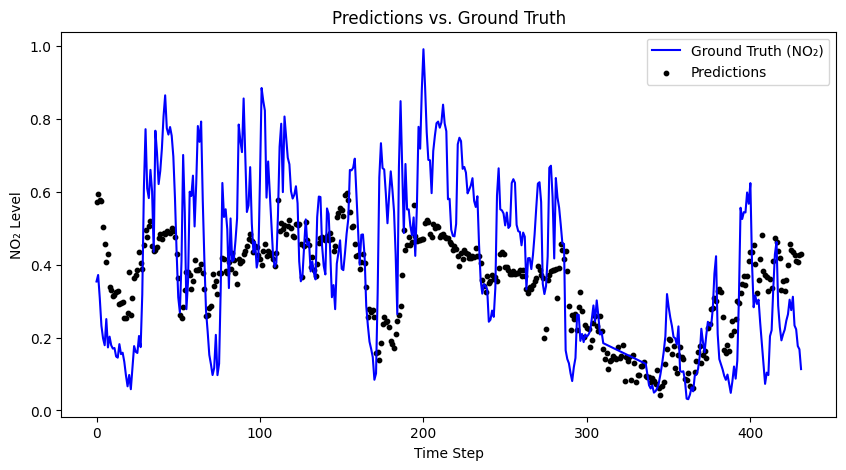

In [ ]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
plt.show()
